In [20]:
import numpy as np
from gensim.models import KeyedVectors
from itertools import repeat
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
model_glove = KeyedVectors.load_word2vec_format('glove.6B.50d_word2vec.txt')

In [3]:
def colapse_into_25(space_50d):
    ndim = space_50d.ndim
    if ndim == 1:  # If a word embedding
        space_25d = np.zeros(25)
        for idx in range(25):
            space_25d[idx] = np.sum(space_50d[idx*2:(idx+1)*2])
    else:
        space_25d = np.zeros([space_50d.shape[0], 25])
        for idx in range(25):
            space_25d[idx] = np.sum(space_50d[idx*2:(idx+1)*2],)
    return space_25d

In [15]:
def colapse_into_10(space_50d):
    ndim = space_50d.ndim
    if ndim == 1:  # If a word embedding
        space_10d = np.zeros(10)
        for idx in range(10):
            space_10d[idx] = np.sum(space_50d[idx*5:(idx+1)*5])
    else:
        space_10d = np.zeros([space_50d.shape[0], 10])
        for idx in range(10):
            space_10d[idx] = np.sum(space_50d[idx*5:(idx+1)*5],)
    return space_10d

In [23]:
embedding = np.load('./mappings.npy')
colapsed_25  = colapse_into_25(embedding)
embedding_pd = pd.DataFrame(embedding)
colapsed_pd = pd.DataFrame(colapsed_25)

In [19]:
colapsed_pd.describe()
#They're pretty similar in terms of a normal gaussian

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,...,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087
std,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,...,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418,0.026418
min,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,...,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778,-3.861778
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,...,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531,7.397531


In [120]:
def get_eq_n_intervals(array):
    """
    Get equally probable n intervals for an array assuming gaussian distribution
    """
    mean = np.mean(array)
    std = 2  # Fixed std. Too extreme values when using std from the array (either 0 or 127).
             # This is very likely because np.std(array) is the standard deviation of all the points of the
             # embedded espace, but what we use in the end is the difference between those points. Calculate 
             # the standard deviation between all posible distances isn't really very affordable to keep this
             # low resource consuming, and also it hard to generalise when you want to use more than 2 words 
             # to calculate the distance. I choosed 2 because seems to work very good. You can try to fine tune it
             # more if you feel like it.

    norm = stats.norm(mean, std)
    intervals = norm.ppf(np.linspace(0, 1, 129))
    return intervals


def get_mappings(embedding):
    """
    Get the mappings for all dimensions of the embedding
    """
    n_columns = embedding.shape[1]
    mappings = []
    for i in range(n_columns):
        mappings.append(get_eq_n_intervals(embedding[:, i]))
    return np.array(mappings)


In [121]:
def embspace_to_midi(word_embedding, n_words):
    """
        word_embedding: The 50dim vector resulting of difference between multiple words embedding
        n_words: Number of words used to create the word_embedding
    """
    embedding = np.load('./mappings.npy')
    reduced_25 = colapse_into_25(embedding)
    mappings = get_mappings(reduced_25)

    reduced_embedding = colapse_into_25(word_embedding)
        
    midi = np.zeros(25)
    for dimension in range(25):
        midi[dimension] = find_range(reduced_embedding[dimension], mappings[dimension])
    return midi


def find_range(point, range_limits):
    n_limits = len(range_limits)
    for limit in range(n_limits - 1):
        if (point > range_limits[limit]) and (point < range_limits[limit + 1]):
            return limit
    raise ValueError

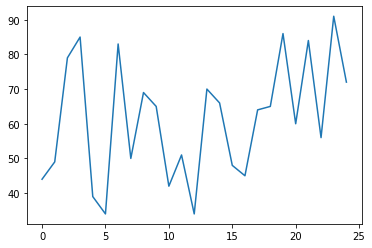

In [184]:
diffwords = model_glove['avocado'] - model_glove['mango']
midi1 = embspace_to_midi(diffwords, 2)
plt.plot(midi1)
plt.show()

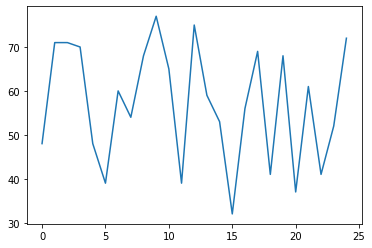

In [181]:
diffwords = model_glove['avocado'] - model_glove['tomato']
midi2 = embspace_to_midi(diffwords, 2)
plt.plot(midi2)
plt.show()

In [176]:
print(np.mean(midi1 - midi2))

4.2


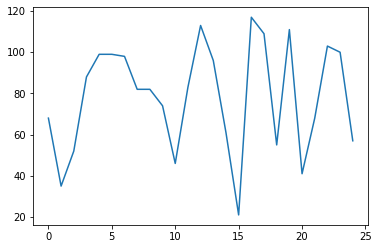

-17.08


In [182]:
diffwords = model_glove['avocado'] - model_glove['republican']
midi3 = embspace_to_midi(diffwords, 2)
plt.plot(midi3)
plt.show()
print(np.mean(midi1 - midi3))

In [178]:
diffwords = model_glove['party'] - model_glove['republican']
midi4 = embspace_to_midi(diffwords, 2)
print(np.mean(midi4 - midi3))

-8.28
